In [12]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Activation
import pickle
from tensorflow.keras.optimizers import RMSprop

In [14]:
path = 'woman_clothing_reviews.txt'
text = open(path, encoding="utf8").read().lower()
print('length of the corpus is: :', len(text))

length of the corpus is: : 928670


In [15]:
# Tokenization

tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

In [31]:
# Getting unique words

unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

print(len(unique_words))

5973


In [17]:
# Feature Engineering

LENGTH_WORD = 5
next_words = []
prev_words = []
for j in range(len(words) - LENGTH_WORD):
    prev_words.append(words[j:j + LENGTH_WORD])
    next_words.append(words[j + LENGTH_WORD])

print(prev_words[0])
print(next_words[0])

print(prev_words[1])
print(next_words[1])

['absolutely', 'wonderful', 'silky', 'and', 'sexy']
and
['wonderful', 'silky', 'and', 'sexy', 'and']
comfortable


In [18]:
Z = np.zeros((2,2,2),  dtype=bool)

Z

array([[[False, False],
        [False, False]],

       [[False, False],
        [False, False]]])

In [19]:
# Storing Features and Labels

X = np.zeros((len(prev_words), LENGTH_WORD, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

In [20]:
# Building our model

model = Sequential()
model.add(LSTM(128, input_shape=(LENGTH_WORD, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

In [21]:
# Model Training 

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Epoch 1/20
1375/1375 [==============================] - 121s 86ms/step - loss: 5.5371 - accuracy: 0.1212 - val_loss: 5.0447 - val_accuracy: 0.1888
Epoch 2/20
1375/1375 [==============================] - 117s 85ms/step - loss: 4.9186 - accuracy: 0.2038 - val_loss: 5.0792 - val_accuracy: 0.1949
Epoch 3/20
1375/1375 [==============================] - 115s 84ms/step - loss: 4.7012 - accuracy: 0.2289 - val_loss: 5.0305 - val_accuracy: 0.1875
Epoch 4/20
1375/1375 [==============================] - 114s 83ms/step - loss: 4.4225 - accuracy: 0.2551 - val_loss: 5.0418 - val_accuracy: 0.1995
Epoch 5/20
1375/1375 [==============================] - 115s 84ms/step - loss: 4.1739 - accuracy: 0.2812 - val_loss: 5.0770 - val_accuracy: 0.2059
Epoch 6/20
1375/1375 [==============================] - 115s 84ms/step - loss: 3.9372 - accuracy: 0.3067 - val_loss: 5.3053 - val_accuracy: 0.1876
Epoch 7/20
1375/1375 [==============================] - 120s 88ms/step - loss: 3.7351 - accuracy: 0.3327 - val_loss: 5

In [22]:
# Saving Model

model.save('next_word_model_v6.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('next_word_model_v6.h5')
history = pickle.load(open("history.p", "rb"))

In [23]:
model = load_model('next_word_model_v6.h5')

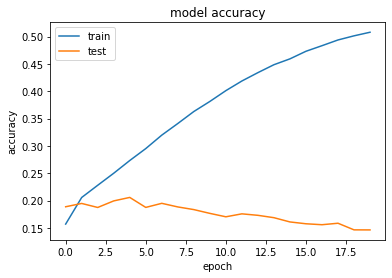

In [24]:
# Evaluating the model

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

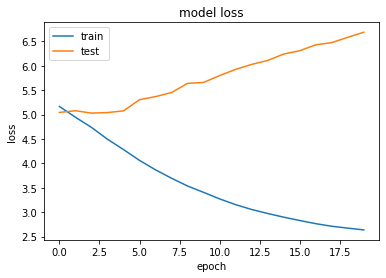

In [25]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [26]:
# Testing Next Word

def prepare_input(text):
    x = np.zeros((1, LENGTH_WORD, len(unique_words)))
    for t, word in enumerate(text.split()):
#        print(word)
        try:
            x[0, t, unique_word_index[word]] = 1
        except:
            pass
    return x

In [27]:
def sample(preds, top_n):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [28]:
def predict_completions(text, n):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [unique_words[idx] for idx in next_indices]


In [29]:
quotes = [
    "had you lived a few centuries",
    "the style is darling and get many"
]

In [30]:
# Predict the next word

for q in quotes:
    seq = q[:12].lower()
#    print(seq)
    print(predict_completions(seq, 10))
    suggestions=predict_completions(seq, 10)
    print(suggestions)

['always', 'white', 'people', 'so', 'retailer', 'things', 'loved', 'items', 'top', '2']
['always', 'white', 'people', 'so', 'retailer', 'things', 'loved', 'items', 'top', '2']
['usually', 'based', 'pounds', 'm', 'type', 'loved', 'item', 'petite', 'jeans', 'jacket']
['usually', 'based', 'pounds', 'm', 'type', 'loved', 'item', 'petite', 'jeans', 'jacket']


In [25]:
import pickle
import joblib

joblib.dump(model, 'NextWord_v2.pkl', compress=1) 

#pickle_file = open('NextWord_v2.pkl', 'wb')     
#pickle.dump(model, pickle_file)
#pickle_file.close()

TypeError: can't pickle weakref objects